In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras

tf.set_random_seed(1234)

from log_utils import get_logger
LOGGER = get_logger("demos")

MAX_LENGTH = 400

import pickle

MBTI_pos = ['I', 'N', 'T', 'J']
MBTI_neg = ['E', 'S', 'F', 'P']

def output_persenality(persenality, original=False):
    MBTI_tag = ""
    for i in range(4):
        MBTI_tag += MBTI_pos[i] if persenality[0][i] > 0.5 else MBTI_neg[i]
    if original:
        print("\nYour MBTI type maybe: {}".format(MBTI_tag))
        print("WHERE")
        for t in range(4):
            if persenality[0][t] > 0.5:
                print("\t{}:({}%)".format(MBTI_pos[t], int(100*persenality[0][t])))
            else:
                print("\t{}:({}%)".format(MBTI_neg[t], int(100*(1-persenality[0][t]))))


In [9]:
model = keras.models.load_model("cnn16seq.h5")
tokenizer = pickle.load(open("tokenizer.p", "rb"))

In [10]:
sentence = input('Please Input a sentence: ')
encoded_docs = tokenizer.texts_to_sequences([sentence])
docs_len = len(encoded_docs[0])
padded_docs = keras.preprocessing.sequence.pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')

persenality = model.predict(padded_docs)
output_persenality(persenality, original=True)


modified_persenality_dict = {}
for t in range(docs_len):
    temp = padded_docs[0][t]
    padded_docs[0][t] = 0
    modified_persenality = model.predict(padded_docs)
    output_persenality(modified_persenality)
    modified_persenality_dict[t] = modified_persenality
    padded_docs[0][t] = temp

for t in range(docs_len):
    for i in range(4):
        modified_persenality_dict[t][0][i] -= persenality[0][i]
    # print(modified_persenality_dict[t][0])

from sty import fg
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

red = [100,0,0,100]
green = [0,100,0,0]
blue = [0,0,150,0]
red_inc = [1 if persenality[0][0]>0.5 else -1,0,0,1 if persenality[0][3]>0.5 else -1]
green_inc = [0,1 if persenality[0][1]>0.5 else -1,0,0]
blue_inc = [0,0,1 if persenality[0][2]>0.5 else -1,0]
for i in range(4):
    print("\n\nIn {}th dimension, the sentense looks like:\n\t".format(i+1), end='')
    for t in range(docs_len):
        print(fg(int(red[i]+5*modified_persenality_dict[t][0][i]*1000*red_inc[i]),
                 int(green[i]+5*modified_persenality_dict[t][0][i]*1000*green_inc[i]),
                 int(blue[i]+5*modified_persenality_dict[t][0][i]*1000*blue_inc[i]))
              + reverse_word_map[padded_docs[0][t]] + fg.rs,end=' ')

Please Input a sentence: Once a bug re- port is received and verified, the software maintenance team would read the textual description of the bug report to locate the potential buggy source files in the source code, and assign appropriate developer to fix the bug accordingly. However, for large and evolving software, the maintenance team may receive a large number of bug reports over a period of time and it is costly to manually locate the potential buggy source files based on bug reports.

Your MBTI type maybe: INFP
WHERE
	I:(75%)
	N:(85%)
	F:(50%)
	P:(53%)


In 1th dimension, the sentense looks like:
	once a bug re port is received and verified the software maintenance team would read the textual description of the bug report to locate the potential buggy source files in the source code and assign appropriate developer to fix the bug accordingly however for large and evolving software the maintenance team may receive a large number of bug reports over a period of time and it is cost

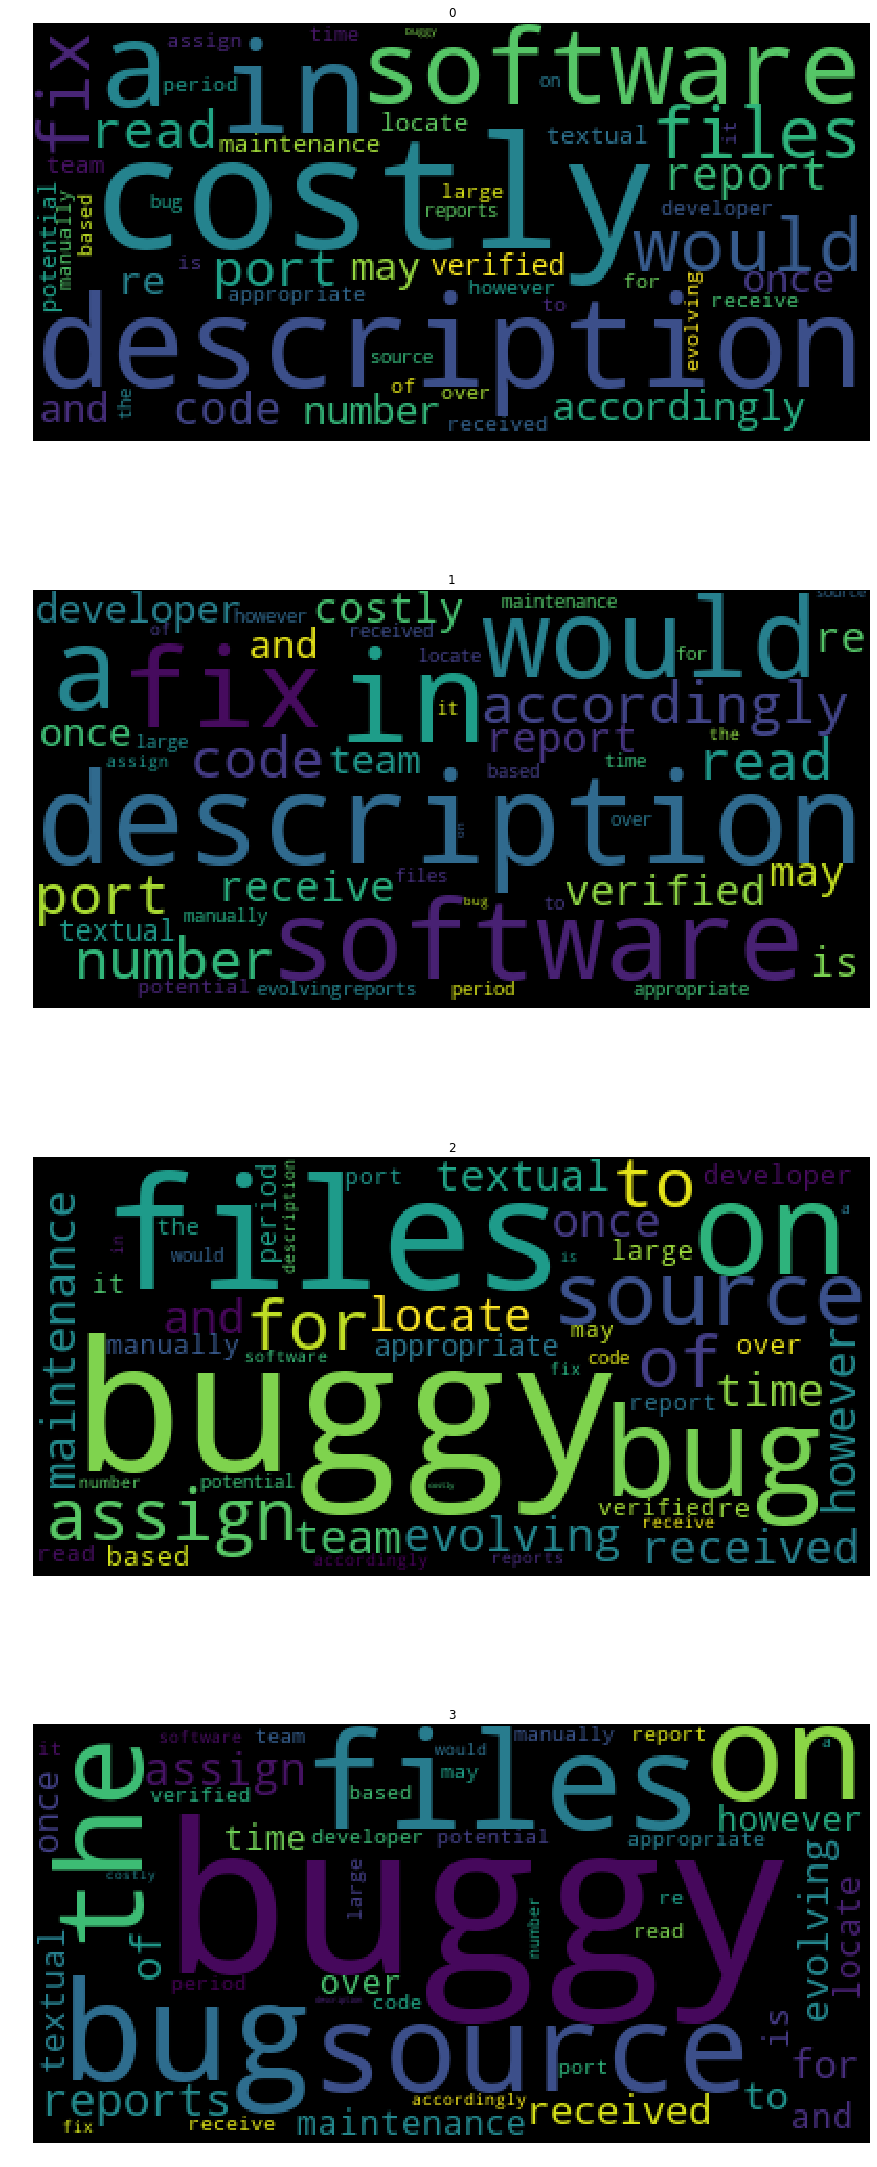

In [25]:
fig, ax = plt.subplots(4, sharex=True, figsize=(15,10*4))

k = 0
for i in range(4):
    temp = {}
    sgn = 1 if persenality[0][i]>0.5 else -1
    for t in range(docs_len):
        temp[reverse_word_map[padded_docs[0][t]]]= int(1000*modified_persenality_dict[t][0][i]*sgn)
    low_bound = -min(temp.values())+1
    for key in temp:
        temp[key] += low_bound
    #print(temp)
    
    wc = WordCloud().generate_from_frequencies(temp)
    ax[k].imshow(wc)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('./MBTIv0.csv')
df.head()

,Unnamed: 0,type,posts,IE,NS,TF,JP
0,0,INFJ,<URL> and intj moments <URL> sportscenter not ...,1,1,0,1
1,1,ENTP,I 'm finding the lack of me in these posts ver...,0,1,1,0
2,2,INTP,"Good one _____ <URL> course , to which I say I...",1,1,1,0
3,3,INTJ,"Dear INTP , I enjoyed our conversation the oth...",1,1,1,1
4,4,ENTJ,You 're fired . <RETURN> That 's another silly...,0,1,1,1


In [26]:
def var_row(row):
    l = []
    for i in row.split('<RETURN>'):
        l.append(len(i.split()))
    return np.var(l)
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))
df.head()

,Unnamed: 0,type,posts,IE,NS,TF,JP,words_per_comment,variance_of_word_counts
0,0,INFJ,<URL> and intj moments <URL> sportscenter not ...,1,1,0,1,14.46,247.325260
1,1,ENTP,I 'm finding the lack of me in these posts ver...,0,1,1,0,29.34,219.835062
2,2,INTP,"Good one _____ <URL> course , to which I say I...",1,1,1,0,21.68,270.098765
3,3,INTJ,"Dear INTP , I enjoyed our conversation the oth...",1,1,1,1,27.90,249.826389
4,4,ENTJ,You 're fired . <RETURN> That 's another silly...,0,1,1,1,24.66,248.821728


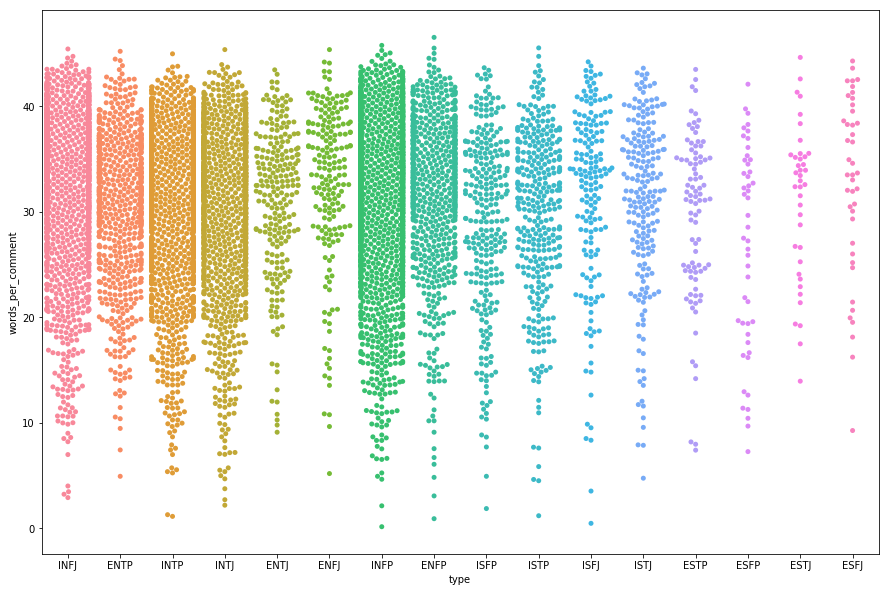

In [27]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=df)

In [28]:
df.groupby('type').agg({'type':'count'})

,type
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


In [2]:
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS

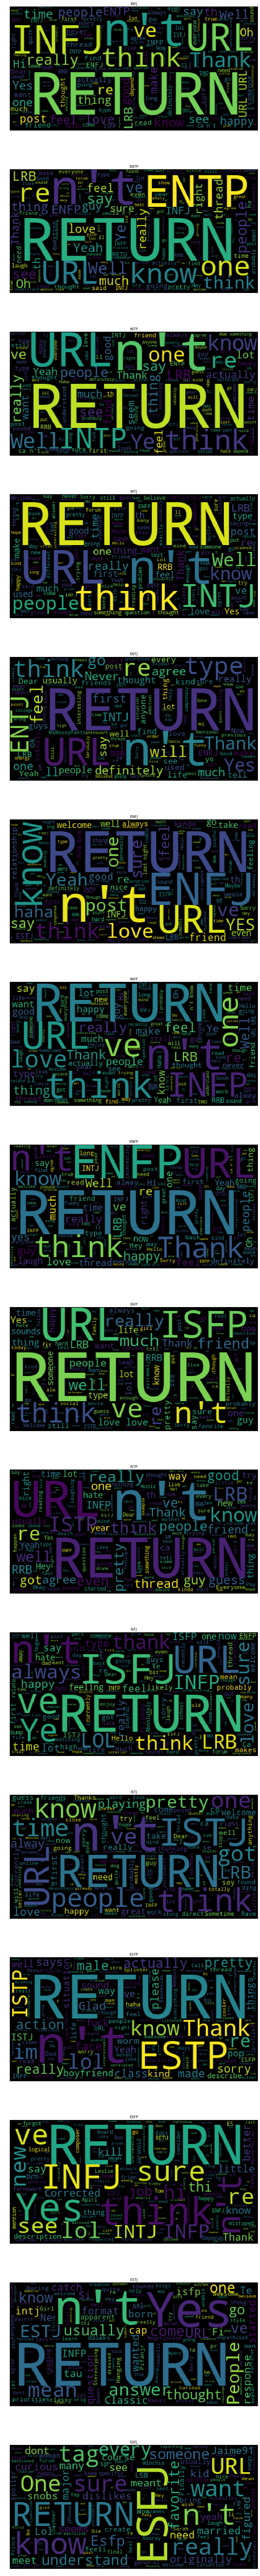

In [7]:
fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,10*len(df['type'].unique())))

k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud().generate(df_4['posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1